In [ ]:
import pandas as pd
import numpy as np
import os, torch, gpytorch
from pathlib import Path
import sys
import warnings
from matplotlib import pyplot as plt
import torch
import math
import pdb
# Import Thermal Tracks modules
project_root = Path().resolve().parents[0]
src_path = project_root / "src"
sys.path.insert(0, str(project_root))  
sys.path.insert(0, str(src_path))

from src.run_full_process import full_gp_process
from src import fit_model as fm

# Ignore all warnings
warnings.filterwarnings("ignore") 

In [ ]:
def make_subject_df(raw,
                    time_col="TIME",
                    value_col="DVTTP",
                    subject_col="ID",
                    condition_label="by_subject"):
    
    df = raw.rename(columns={time_col:"x", value_col:"y", subject_col:"uniqueID"}).copy()
    df["condition"] = str(condition_label)
    
    df["x"] = pd.to_numeric(df["x"], errors="coerce")
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    df = df.dropna(subset=["x","y"])
    # Make the one observation for one time per ID 
    df = (df.groupby(["uniqueID","condition","x"], as_index=False)["y"].mean())
    # filter 
    df = df.groupby("uniqueID").filter(lambda d: d["x"].nunique() >= 2)
    return df.sort_values(["uniqueID","x"])[["condition","uniqueID","x","y"]]

In [ ]:
def train_subject_models(tpptr_df, parameters):
    """
    null_dataset=False
    """
    os.makedirs(str(parameters["result_dir"]), exist_ok=True)
    return fm.train_model(tpptr_df, parameters, null_dataset=False)

In [ ]:
def predict_subject_curves(train_results, tpptr_df, n_grid=100):
    """
    Predicts the posterior mean and 95% confidence region for each unique subject  
    on a dense time grid generated within their observed time range.
    ----parameter---
    train_results : dict
        Results containing the trained models (full_model_list, full_likelihood_list, etc.).
    tpptr_df : DataFrame
        Training data used to determine the subject-specific time ranges.
    n_grid : int
        Number of points in the prediction grid.
    pred_df : DataFrame
        Columns: ['uniqueID', 'condition', 'x', 'mean', 'lower', 'upper'].
    """
    full_model = train_results["full_model_list"]
    full_like  = train_results["full_likelihood_list"]
    meta       = train_results["full_model_order"]   # [(uniqueID, condition, model_id), ...]
    full_model.eval(); full_like.eval()

    # 每个受试者自己的时间范围
    subj_ranges = tpptr_df.groupby("uniqueID")["x"].agg(["min","max"]).to_dict("index")

    frames = []
    with torch.no_grad():
        for (uid, cond, _), m, lik in zip(meta, full_model.models, full_like.likelihoods):
            lo, hi = subj_ranges[uid]["min"], subj_ranges[uid]["max"]
            if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
                x_grid = np.array([lo], dtype=float)           # 只有一个点的退化情况
            else:
                x_grid = np.linspace(lo, hi, n_grid)

            x_t = torch.as_tensor(x_grid, dtype=torch.float64)
            pred = lik(m(x_t))
            lower, upper = pred.confidence_region()

            frames.append(pd.DataFrame({
                "uniqueID": uid,
                "condition": cond,
                "x": x_grid,
                "mean": pred.mean.detach().cpu().numpy(),
                "lower": lower.detach().cpu().numpy(),
                "upper": upper.detach().cpu().numpy(),
            }))

    return pd.concat(frames, ignore_index=True)

Data Preparation

In [ ]:
torch.set_default_dtype(torch.float64)
# Load example data (E.coli cell lysate - Mateus et al. (2018)
example_data_path = project_root / 'Data/'

# Load the data
csv_path = example_data_path / "scenar1_subscenar1_train.csv"
raw1 = pd.read_csv(csv_path)
csv_path = example_data_path / "scenar1_subscenar1_test.csv"
raw2 = pd.read_csv(csv_path)

raw = pd.concat([raw1, raw2], ignore_index=True)
#raw = raw.sort_values(by=["ID", "TIME"]).reset_index(drop=True)
raw_temp = raw1

PATIENT_COL = 'ID'
ARM_COL = 'Arm' 
patients = raw_temp[[PATIENT_COL, ARM_COL]].drop_duplicates(PATIENT_COL)
sample_ids = patients.groupby(ARM_COL)[PATIENT_COL]\
                    .apply(lambda s: s.sample(n=min(15, len(s)), random_state=42))\
                    .reset_index(level=0, drop=True)
raw_temp = raw_temp[raw_temp[PATIENT_COL].isin(sample_ids)]

print(raw_temp[PATIENT_COL].nunique())
raw = raw_temp.sort_values(by=["ID", "TIME"]).reset_index(drop=True)    


tpp_subject_df = make_subject_df(
    raw, time_col="TIME", value_col="DVTTP", subject_col="ID", condition_label="by_subject"
)

tpp_subject_df = tpp_subject_df.groupby('uniqueID').filter(lambda d: d['x'].nunique() >= 2)

SCALE_MAX = 42.0

#tpp_subject_df["y"] = tpp_subject_df["y"].clip(0, SCALE_MAX) / SCALE_MAX  # -> y∈[0,1]
eps = 1e-4

y01 = np.clip(tpp_subject_df["y"]/SCALE_MAX, eps, 1-eps)
tpp_subject_df["y"] = np.log(y01/(1-y01))

g = tpp_subject_df.groupby("uniqueID")["x"]
tpp_subject_df["x"] = (tpp_subject_df["x"] - g.transform("min")) / (g.transform("max") - g.transform("min") + 1e-8)


Model building

In [ ]:
# Parameter
results_dir = Path("results/subject_gp"); results_dir.mkdir(parents=True, exist_ok=True)
parameters = {
    "result_dir": f"{results_dir}/",
    "lengthscale_prior": gpytorch.priors.GammaPrior(2, 1), 
    "lengthscale_minconstraint": "min",  # 'min'|'mean'|'median'|'max'|None
    "lengthscale_mult": 0.1,
    "control_condition": "by_subject",  
    "perturbation":  "by_subject",    
    "training_iterations": 200,
    "learningRate": 0.1,
    "amsgrad": False,
}

#Train
train_res = train_subject_models(tpp_subject_df, parameters)

# 4) Test
pred_df = predict_subject_curves(train_res, tpp_subject_df, n_grid=100)

# 5) Save 
out_csv = Path(parameters["result_dir"]) / "subject_level_predictions.csv"
pred_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


- [x] 1. Build and fit full model
    - [x] Prepare input for GP process
    - [x] Build models
    - [x] Initialize models
    - [x] Train models
    - [x] Compute mll for full models
    - [x] Save models and training results
- [ ] 2. Creating a joint model and null dataset
- [ ] 3. Evaluate and predict models
- [ ] 4. Build and fit null model
- [ ] 5. Compute likelihood ratio test statistics
- [ ] 6. Combine and create result files


Saved: results/subject_gp/subject_level_predictions.csv


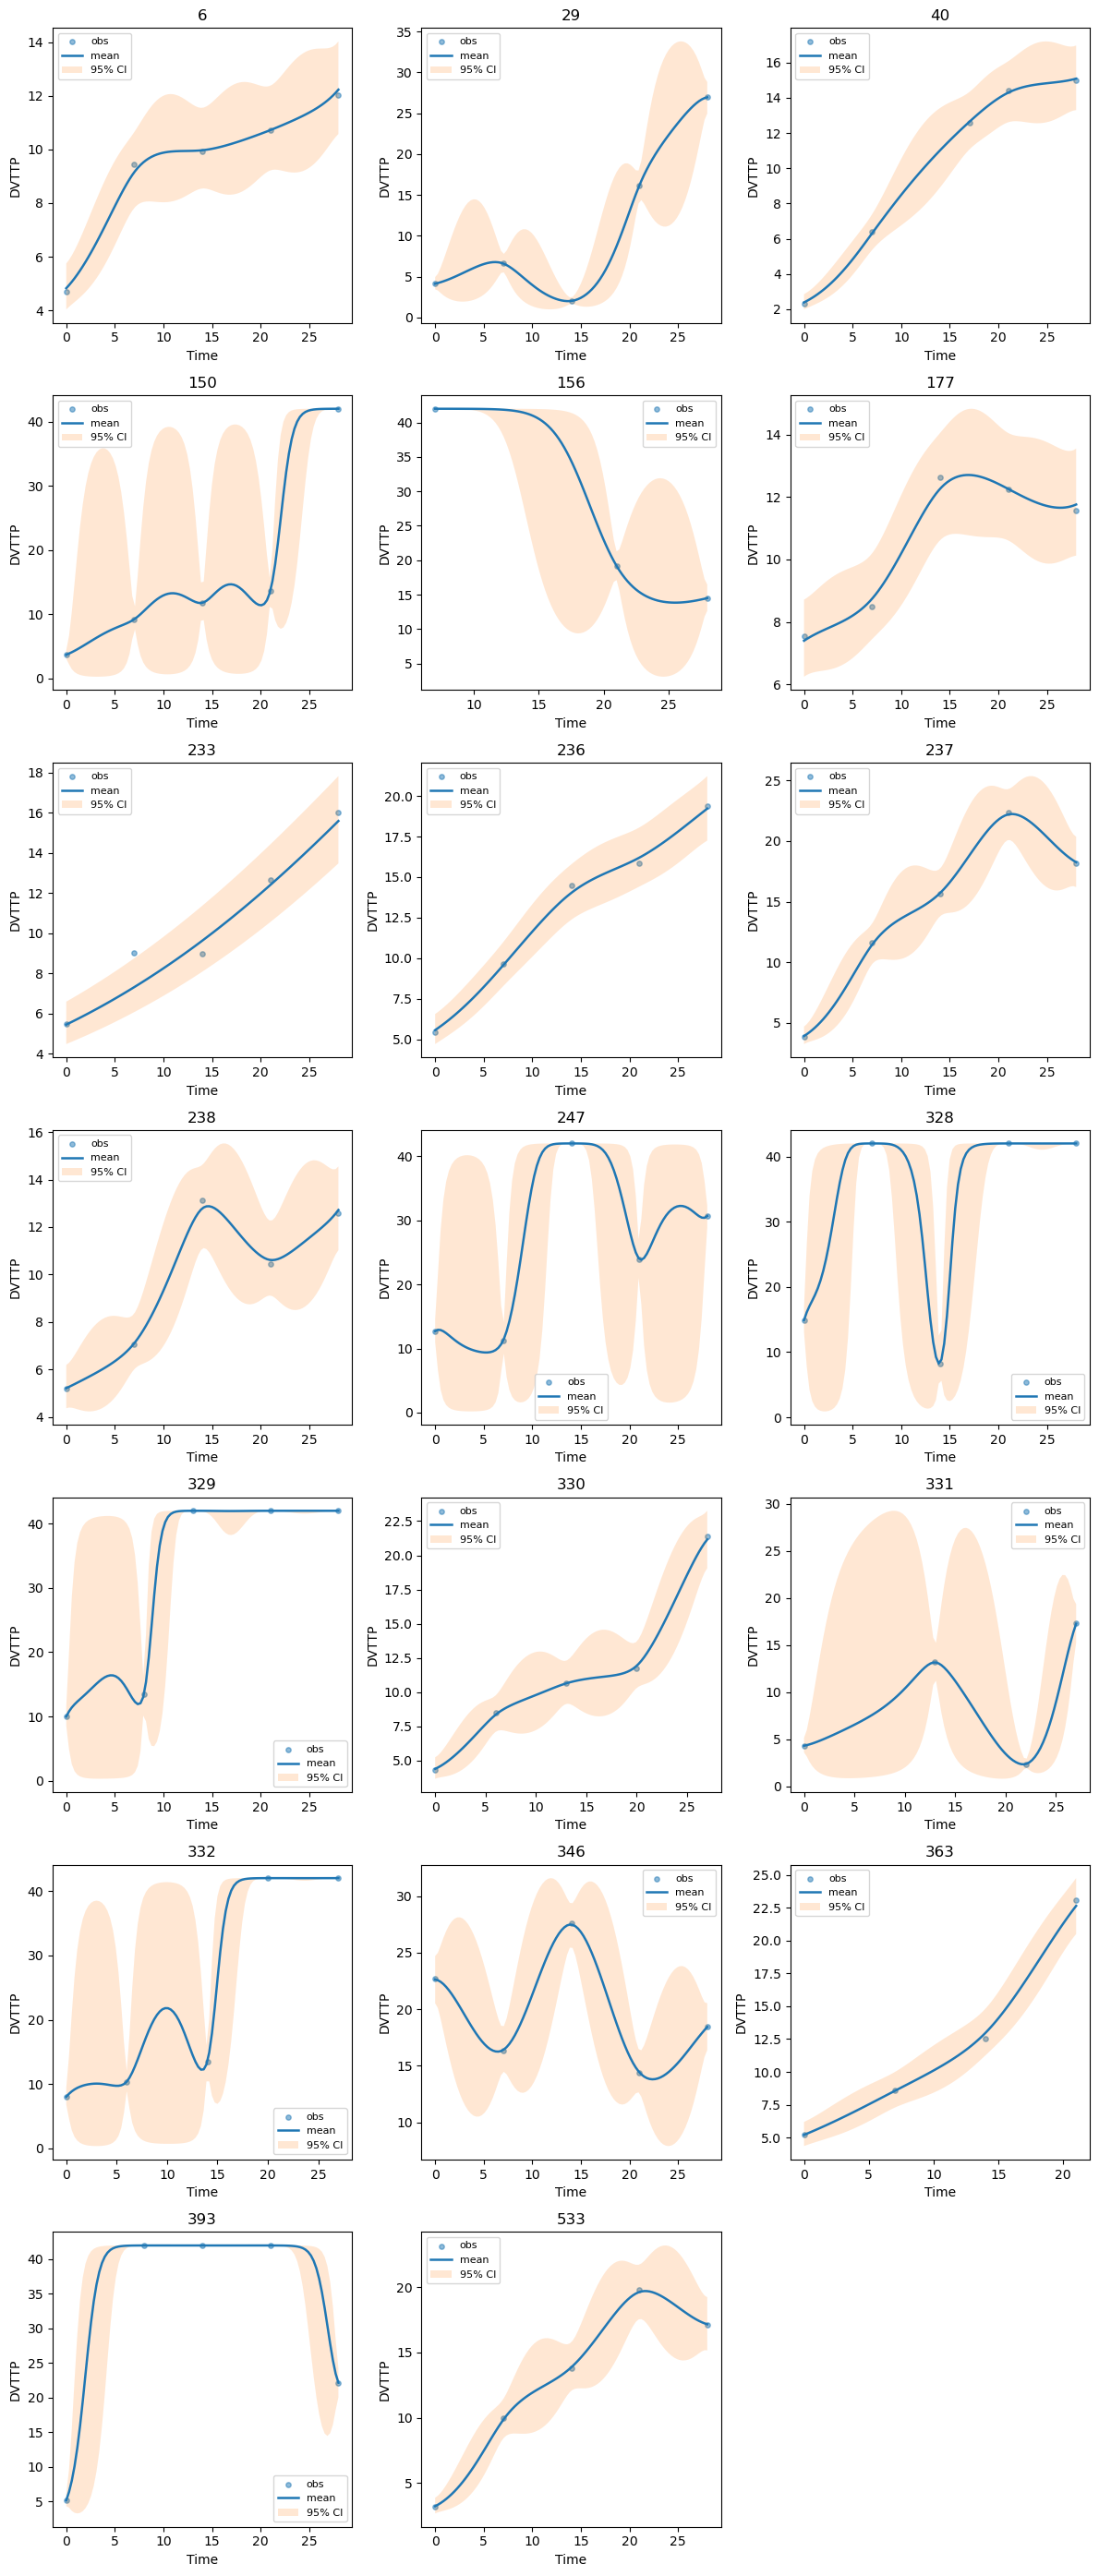

In [ ]:
# Extract Time Statistics
stats_time = (raw.groupby("ID")["TIME"]
                .agg(x_min="min", x_max="max")
                .reset_index()
                .rename(columns={"ID": "uniqueID"}))

# Process pred data
pred_plot = pred_df.copy()
#pred_plot[["mean","lower","upper"]] = pred_plot[["mean","lower","upper"]].clip(0,1) * SCALE_MAX
pred_plot[["mean","lower","upper"]] = 1/(1+np.exp(-pred_plot[["mean","lower","upper"]]))
pred_plot[["mean","lower","upper"]] *= SCALE_MAX
pred_plot = pred_plot.merge(stats_time, on="uniqueID", how="left")
pred_plot["Time_orig"] = pred_plot["x"] * (pred_plot["x_max"] - pred_plot["x_min"]) + pred_plot["x_min"]

# Scale back to DVTTP range
obs_plot = tpp_subject_df.copy()
obs_plot["y_plot"] = 1 / (1 + np.exp(-obs_plot["y"])) * SCALE_MAX
obs_plot = obs_plot.merge(stats_time, on="uniqueID", how="left")
obs_plot["Time_orig"] = obs_plot["x"] * (obs_plot["x_max"] - obs_plot["x_min"]) + obs_plot["x_min"]


# Select IDs for visualization
subs = pred_df["uniqueID"].drop_duplicates().head(20).tolist()  
n = len(subs); ncols = 3; nrows = (n + ncols - 1)//ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), sharex=False, sharey=False)
axes = axes.ravel()

for ax, sid in zip(axes, subs):
    sp = pred_plot[pred_plot.uniqueID == sid]
    sr = obs_plot.loc[obs_plot["uniqueID"].eq(sid)]
    ax.scatter(sr["Time_orig"], sr["y_plot"], s=15, alpha=0.5, label="obs")
    ax.plot(sp["Time_orig"], sp["mean"], lw=1.8, label="mean")
    ax.fill_between(sp["Time_orig"], sp["lower"], sp["upper"], alpha=0.18, label="95% CI")
    ax.set_title(sid); ax.set_xlabel("Time"); ax.set_ylabel("DVTTP")
    ax.legend(fontsize=8)
for ax in axes[n:]: ax.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
def forecast_subjects(train_results,
                      train_df,
                      end_raw=56.0,          # Forecasting time
                      n_points=100,
                      stats_time=None,        # DataFrame: ['uniqueID','x_min','x_max']
                      start_mode="last",      # "last": last observation → end_raw
                      start_raw=29.0):
    """
    Forecast for each subject from their last observed time to last+horizon.
    train_df columns: uniqueID, x, (y), condition
    Returns: DataFrame [uniqueID, condition, x, mean, lower, upper, is_future=True]
    """
    if stats_time is None:
        raise ValueError("No stats_time")

    full_model = train_results["full_model_list"]
    full_like  = train_results["full_likelihood_list"]
    meta       = train_results["full_model_order"] 

    full_model.eval(); full_like.eval()

    # The stats time
    last_raw = dict(zip(stats_time["uniqueID"], stats_time["x_max"]))

    rows = []
    with torch.no_grad():
        for (uid, cond, _), m, lik in zip(meta, full_model.models, full_like.likelihoods):
            st = stats_time.loc[stats_time["uniqueID"] == uid]
            if st.empty:
                continue
            xmin = float(st["x_min"].iloc[0])
            xmax = float(st["x_max"].iloc[0])
            span = xmax - xmin if (xmax - xmin) > 1e-12 else 1.0  

            # --- Set the raw time grid ---
            if start_mode == "last":
                s = min(last_raw.get(uid, xmax), end_raw)  # Start from the last observed time 
            else:
                s = float(start_raw)
            if s >= end_raw:
                x_raw = np.array([end_raw], dtype=float)
            else:
                x_raw = np.linspace(s, float(end_raw), max(2, n_points))

            # --- Scale to the training domain ---
            x_scaled = (x_raw - xmin) / (span + 1e-8)

            # --- Pred ---
            dtype = m.train_inputs[0].dtype 
            x_t = torch.as_tensor(x_scaled, dtype=dtype)
            pred = lik(m(x_t))
            lo_t, hi_t = pred.confidence_region()

            rows.append(pd.DataFrame({
                "uniqueID": uid,
                "condition": cond,
                "x": x_scaled,                        
                "x_raw": x_raw,                         
                "mean": pred.mean.cpu().numpy(),
                "lower": lo_t.cpu().numpy(),
                "upper": hi_t.cpu().numpy(),
                "is_future": True,
            }))

    return pd.concat(rows, ignore_index=True)

In [ ]:
# Prediction from last observation to 56 days
future_df = forecast_subjects(train_res, tpp_subject_df,
                              end_raw=56.0, n_points=200,
                              stats_time=stats_time,
                              start_mode="last")  
#future_df = forecast_subjects(train_res, tpp_subject_df, horizon=28, n_points=100)

Result analysis

In [ ]:
# Load test data
csv_path = example_data_path / "scenar1_subscenar1_test.csv"
raw2 = pd.read_csv(csv_path)

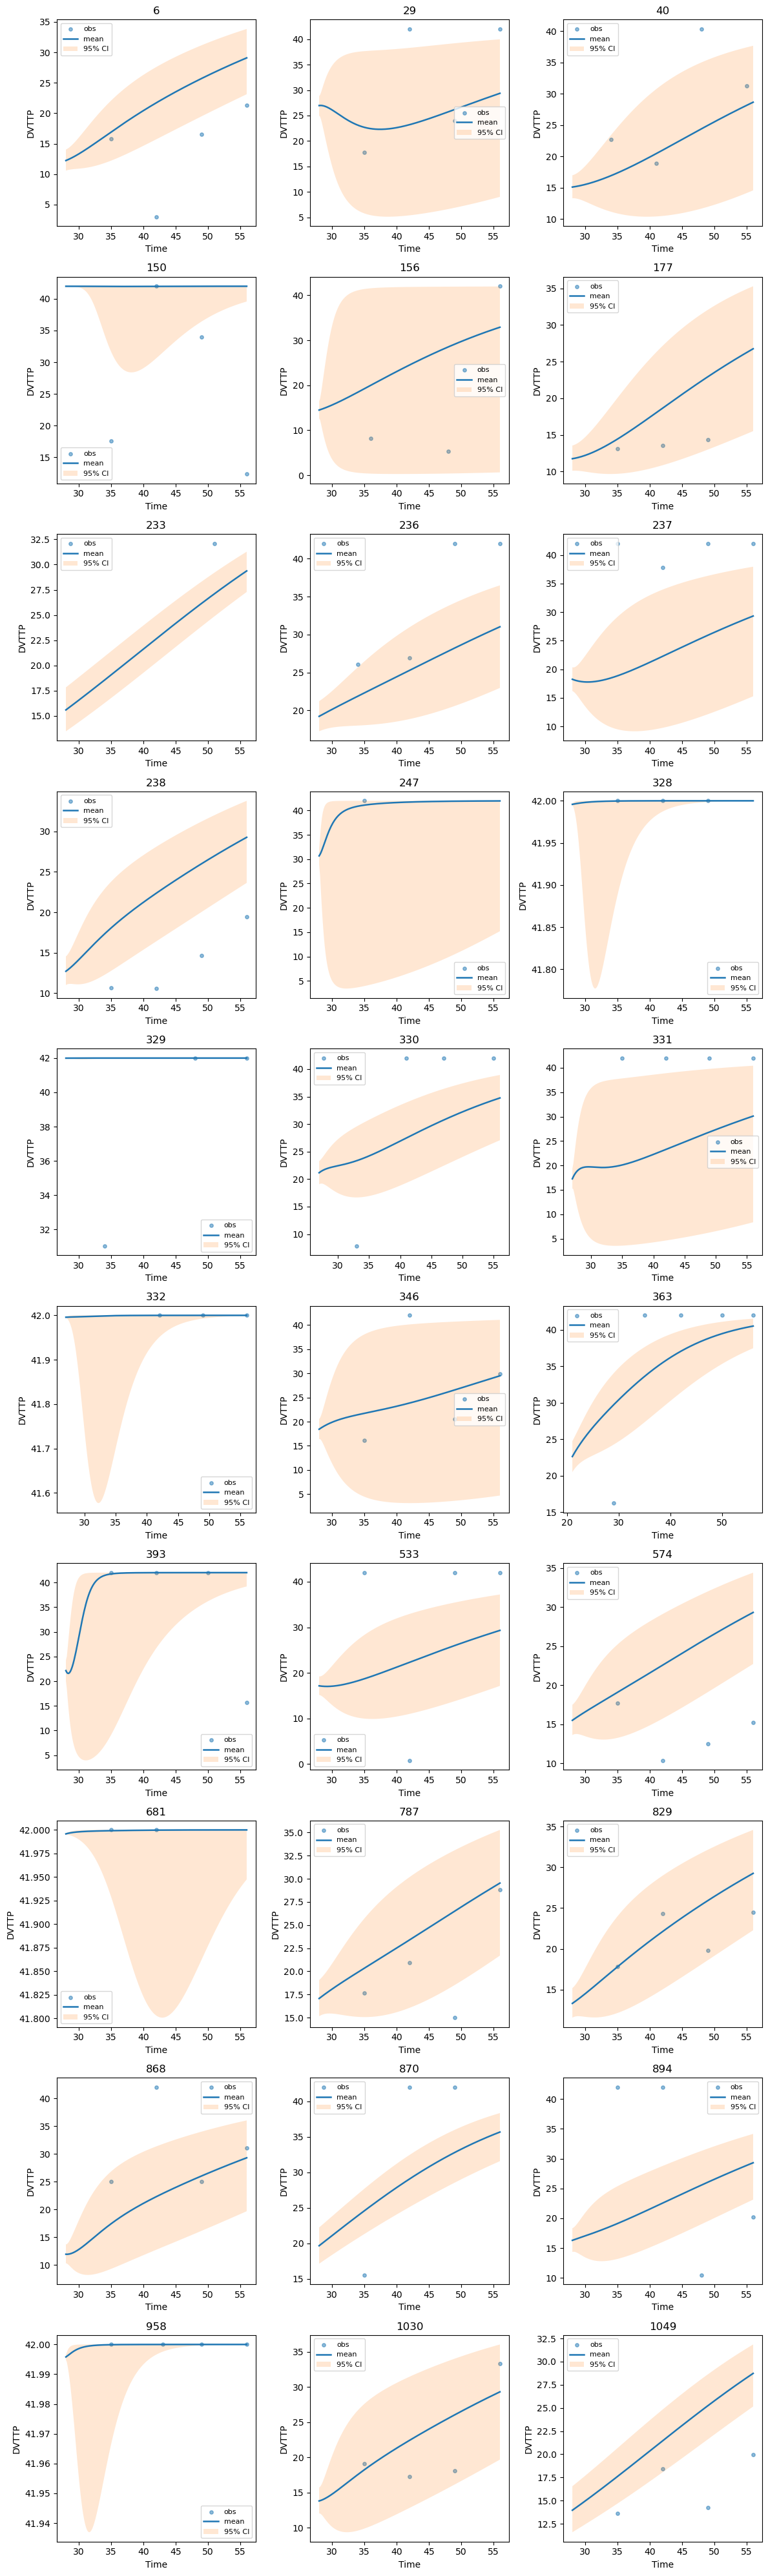

In [ ]:
pred_plot = future_df.copy()
#pred_plot[["mean","lower","upper"]] =1/(1+np.exp(-pred_plot[["mean","lower","upper"]]))
#pred_plot[["mean","lower","upper"]] *= SCALE_MAX

#pred_plot[["mean","lower","upper"]] = pred_plot[["mean","lower","upper"]].clip(0,1) * SCALE_MAX

# Back transform to original scale
pred_plot[["mean","lower","upper"]] = 1/(1+np.exp(-pred_plot[["mean","lower","upper"]]))
pred_plot[["mean","lower","upper"]] *= SCALE_MAX
pred_plot = pred_plot.merge(stats_time, on="uniqueID", how="left")
pred_plot["Time_orig"] = pred_plot["x"] * (pred_plot["x_max"] - pred_plot["x_min"]) + pred_plot["x_min"]


# Select ID for visulization
subs = pred_df["uniqueID"].drop_duplicates().head(30).tolist()  
n = len(subs); ncols = 3; nrows = (n + ncols - 1)//ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), sharex=False, sharey=False)
axes = axes.ravel()

for ax, sid in zip(axes, subs):
    sp = pred_plot[pred_plot.uniqueID == sid]
    sr = raw2[raw2["ID"] == sid]
    ax.scatter(sr["TIME"], sr["DVTTP"], s=15, alpha=0.5, label="obs")
    ax.plot(sp["x_raw"], sp["mean"], lw=1.8, label="mean")
    ax.fill_between(sp["x_raw"], sp["lower"], sp["upper"], alpha=0.18, label="95% CI")
    ax.set_title(sid); ax.set_xlabel("Time"); ax.set_ylabel("DVTTP")
    ax.legend(fontsize=8)
for ax in axes[n:]: ax.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
def evaluate_in_sample(train_results):
    """
    Evaluates the in-sample performance for each subject using their training inputs.

    Metrics calculated per subject:
    - Root Mean Square Error (RMSE), Mean Absolute Error (MAE)
    - 95% Coverage Probability and Mean Interval Width (MIW)
    - Log Predictive Density (LPD) (Exact for Gaussian; approximated otherwise)

    """
    fm = train_results["full_model_list"]
    fl = train_results["full_likelihood_list"]
    meta = train_results["full_model_order"]  # list of (uniqueID, condition, model_id)

    rows = []
    # Set models and likelihoods to evaluation mode
    fm.eval(); fl.eval()
    
    with torch.no_grad():
        for (uid, cond, _), m, lik in zip(meta, fm.models, fl.likelihoods):
            xtr = m.train_inputs[0]  # Training inputs (x)
            ytr = m.train_targets    # Training targets (y)
            
            # Posterior predictive distribution
            pred = lik(m(xtr)) 
            print(pred)
            
            mu   = pred.mean
            var  = pred.variance.clamp_min(1e-12)  # Clamp variance to prevent issues with log(0)
            # sd   = var.sqrt() # (sd is calculated but not used later)
            lo, hi = pred.confidence_region()  # 95% confidence region

            # --- Point Forecast Errors ---
            mae  = torch.mean(torch.abs(ytr - mu)).item()
            rmse = torch.sqrt(torch.mean((ytr - mu)**2)).item()

            # --- Uncertainty & Calibration Metrics ---
            # 95% Coverage Probability
            covered = ((ytr >= lo) & (ytr <= hi)).float().mean().item()
            # Mean Interval Width
            miw = torch.mean(hi - lo).item()

            # --- Log Predictive Density ---
            if isinstance(lik, gpytorch.likelihoods.GaussianLikelihood):
                # Exact LPD for Gaussian
                lpd = (-0.5*torch.log(2*torch.pi*var) - 0.5*((ytr-mu)**2)/var).sum().item()
            else:
                # Approximate LPD using Gaussian formula
                lpd = (-0.5*torch.log(2*torch.pi*var) - 0.5*((ytr-mu)**2)/var).sum().item()

            rows.append({
                "uniqueID": uid, "condition": cond,
                "n": int(ytr.numel()),
                "MAE": mae, "RMSE": rmse,
                "Cover95": covered, "MeanIWidth": miw,
                "LPD": lpd
            })

    df = pd.DataFrame(rows)
    # Aggregate results across all subjects
    overall = {
        "n_subjects": df.shape[0],
        "MAE_mean": df["MAE"].mean(),
        "RMSE_mean": df["RMSE"].mean(),
        "Cover95_mean": df["Cover95"].mean(),
        "MeanIWidth_mean": df["MeanIWidth"].mean(),
        "LPD_sum": df["LPD"].sum()
    }
    return overall, df

In [ ]:
overall, per_subj = evaluate_in_sample(train_res)
print(overall); per_subj.sort_values("RMSE").head()